# Background
- **Author**: `<林宜萱>`
- **Created At**: `<2025-10-26>`
- **Path to Training Data：extent-of-discount-rate-DE_train.csv**
- **Path to Testing Data：extent-of-discount-rate-DE_test.csv**
- **Model Specification 
    - Method：Random Forest Regression
    - Variables：
    Dependent Variable (y): DiscountRate  
    Independent Variables (X):  
    ["Age", "AccumulatedPositiveRate", "SalePeriod",
 "PlayerGrowthRate1W", "PlayerGrowthRate2W", "PlayerGrowthRate1M",
 "FollowersGrowthRate1W", "FollowersGrowthRate2W", "FollowersGrowthRate1M",
 "PositiveRateGrowthRate1W", "PositiveRateGrowthRate2W", "PositiveRateGrowthRate1M",
 "DLC_since_last_discount", "Sequel_since_last_discount"]
    - Tuning Parameters:    
      -1W:{'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}  
      -2W:{'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 200}    
      -1M:{'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}  

    - Optimization Method：
    The model is trained via ensemble learning using Random Forests, which aggregates multiple decision trees trained on bootstrapped subsets of data to minimize prediction variance and capture non-linear relationships among variables.
- **Main Findings and Takeaways：**
    - In-sample `< R², RMSE>`:  
    1w(0.8316, 0.0786)、2w(0.7885, 0.0902)、1m(0.8250, 0.0802)
    - Out-sample `< R², RMSE>`:  
    1w(0.5747, 0.1299)、2w(0.6354, 0.1105)、1m(0.5859, 0.1282)  
    - Feature Importance Ranking:  
  | 1 | AccumulatedPositiveRate |   
  | 2 | Age |   
  | 3 | FollowersGrowthRate |   
  | 4 | DiscountDuration |   
  | 5 | PositiveRateGrowthRate |   
  | 6 | PlayerGrowthRate |   
  | 7 | MultiPlayer |   
  | 8 | DiscountFreq3M |   

- Interpretation:  
  - 模型在訓練資料上表現優異（R² 約 0.8），同時在測試資料上仍維持良好的解釋力（R² 約 0.6），顯示 Random Forest 能有效捕捉主要特徵模式，且未出現明顯的過度擬合。    
  - 在所有變數中，**AccumulatedPositiveRate**、**Age** 以及 **FollowersGrowthRate** 對折扣率的影響最大。   
  - **long-term user sentiment** (positive review accumulation) and **community engagement** (follower and player growth) 是影響折扣策略幅度的主要因素。    
  - 相較之下，與**recent discount history** (DLC and sequel timing)相關的變數影響力較小，定價決策更可能受到遊戲表現與聲譽的影響，而非過往促銷紀錄。

In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error, make_scorer, mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [4]:
df = pd.read_csv('../data/processed/extent-of-discount-rate-DE.csv')
df_dummies = pd.get_dummies(df, columns=['GameID'], drop_first=True)

def prepare_xy(df, feature_cols, target_col):
    X = df[feature_cols].copy()
    y = df[target_col].copy()
    # 將 bool 欄轉成 int
    X = X.astype({col: 'int' for col in X.select_dtypes(bool).columns})
    return X, y

# 直接用 sklearn 做隨機切分
train, test = train_test_split(
    df_dummies,
    test_size=0.2,
    random_state=42,
    shuffle=True
)


In [5]:
df_sale = df


In [6]:
df.head()

,Date,GameID,Type,MultiPlayer,Publisher,ConstantDiscount,Final price,OriginPrice,DiscountRate,DiscountDuration,...,PlayerGrowthRate2W,PlayerGrowthRate1M,FollowersGrowthRate1W,FollowersGrowthRate2W,FollowersGrowthRate1M,PositiveRateGrowthRate1W,PositiveRateGrowthRate2W,PositiveRateGrowthRate1M,DLC_since_last_discount,Sequel_since_last_discount
0,2023-06-29,10,Action,1,Valve,0,18.0,186.0,0.903226,14,...,-0.033624,-0.037584,0.000673,0.001362,0.003116,0.000053,0.000015,0.000023,0,0
1,2023-09-12,10,Action,1,Valve,0,18.0,186.0,0.903226,7,...,0.022963,0.003837,0.000553,0.001087,0.002301,0.000004,0.000031,-0.000026,0,0
2,2023-11-21,10,Action,1,Valve,0,18.0,186.0,0.903226,7,...,-0.039165,0.015256,0.001381,0.002082,0.004059,-0.000146,-0.000165,-0.000152,0,0
3,2023-12-21,10,Action,1,Valve,0,19.0,186.0,0.897849,14,...,-0.033895,-0.006214,0.000790,0.001743,0.004781,0.000016,0.000014,-0.000011,0,0
4,2024-03-14,10,Action,1,Valve,0,18.0,186.0,0.903226,7,...,0.044649,0.012697,0.000952,0.001814,0.003629,0.000002,-0.000022,-0.000005,0,0


In [7]:
# 定義特徵與目標 
base_features = [
    "Age", "AccumulatedPositiveRate", "SalePeriod", "DiscountFreq3M","MultiPlayer","DiscountDuration",
    #"DLC_since_last_discount", "Sequel_since_last_discount"
]

feature_sets = {
    "1W": ["PlayerGrowthRate1W", "FollowersGrowthRate1W", "PositiveRateGrowthRate1W"],
    "2W": ["PlayerGrowthRate2W", "FollowersGrowthRate2W", "PositiveRateGrowthRate2W"],
    "1M": ["PlayerGrowthRate1M", "FollowersGrowthRate1M", "PositiveRateGrowthRate1M"]
}

y = df["DiscountRate"]

In [8]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    # Fit
    model.fit(X_train, y_train)

    # If model is RandomizedSearchCV → use best_estimator_
    if hasattr(model, "best_estimator_"):
        est = model.best_estimator_
    else:
        est = model

    # Feature importance
    if hasattr(est, "feature_importances_"):
        importances = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': est.feature_importances_
        }).sort_values(by='Importance', ascending=False)

        print("\nFeature Importances:")
        display(importances)
    else:
        print("\nThis model does not provide feature_importances_.")
    

    # Predictions
    y_pred_train = est.predict(X_train)
    y_pred_test = est.predict(X_test)

    # Metrics
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_rmse = root_mean_squared_error(y_train, y_pred_train)
    test_rmse = root_mean_squared_error(y_test, y_pred_test)

    # Summary
    results = [{
        "Best Params": model.best_params_ if hasattr(model, "best_params_") else "N/A",
        "Train R²": round(train_r2, 4),
        "Test R²": round(test_r2, 4),
        "Train RMSE": round(train_rmse, 4),
        "Test RMSE": round(test_rmse, 4)
    }]

    result_df = pd.DataFrame(results, index=['result'])

    print(f"\n=== {name} ===")
    display(result_df)

    return result_df, y_pred_test


In [9]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def find_best_params_grid_searchCV_regression(X_train, y_train, X_test, y_test, param_grid, cv_splits=5):

    # 1. 初始化 RandomForestRegressor
    rf = RandomForestRegressor(random_state=71, max_features='sqrt')

    # 2. 設定交叉驗證策略（迴歸用 KFold）
    kf = KFold(n_splits=cv_splits, shuffle=True, random_state=71)

    # 3. 定義評分標準：我們用 r2 作為 scorer（也可以用 neg_mean_squared_error）
    scorer = make_scorer(r2_score)

    # 4. GridSearchCV
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        scoring=scorer,  # 使用 R² 作為評分
        cv=kf,
        verbose=1,
        n_jobs=-1
    )

    # 5. 執行網格搜尋（只用 training set 來 fit）
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_

    # 6. 預測 train / test
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)

    # 7. 計算指標
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_rmse = rmse(y_train, y_pred_train)
    test_rmse = rmse(y_test, y_pred_test)

    # 8. 準備輸出表格
    results = {
        "Train R2": [round(train_r2, 4)],
        "Test R2": [round(test_r2, 4)],
        "Train RMSE": [round(train_rmse, 4)],
        "Test RMSE": [round(test_rmse, 4)],
    }
    df = pd.DataFrame(results, index=["RandomForest"])

    # 9. 回傳最佳參數、結果表、以及最佳模型
    return grid_search.best_params_, df, best_model


In [10]:
feature_cols = [
    "Age", "AccumulatedPositiveRate", "DiscountDuration","DiscountFreq3M", "MultiPlayer", "SalePeriod",
    "PlayerGrowthRate2W", "FollowersGrowthRate2W", "PositiveRateGrowthRate2W"]
baseline_model = RandomForestRegressor(      
    n_estimators=200,
    max_features='sqrt',
    max_depth=6,
    min_samples_split=2,
    random_state=71
)

In [11]:
X_train, y_train = prepare_xy(train, feature_cols, 'DiscountRate')
X_test, y_test = prepare_xy(test, feature_cols, 'DiscountRate')

In [12]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6, 7],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [2, 3, 4, 5, 8, 10]
}

best_param, result_df, best_model = find_best_params_grid_searchCV_regression(
    X_train, y_train, X_test, y_test, param_grid
)

print("Best params:", best_param)
print(result_df)


Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best params: {'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
              Train R2  Test R2  Train RMSE  Test RMSE
RandomForest    0.8035   0.6812      0.0869     0.1033


c:\Users\user\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [13]:
from sklearn.model_selection import learning_curve


model = RandomForestRegressor(
    n_estimators=200,
    max_features='sqrt',
    max_depth=7,
    min_samples_split=2,
    min_samples_leaf=2,
    bootstrap=True
)
result1, y_pred_baseline = evaluate_model('baseline', baseline_model, X_train, y_train, X_test, y_test)
result2, y_pred_selection = evaluate_model('selection', model, X_train, y_train, X_test, y_test)

combined_results = pd.concat(
    [result1, result2],
    keys=['baseline', 'selection']
)

print("\n模型比較結果:")
print(combined_results)


Feature Importances:


,Feature,Importance
1,AccumulatedPositiveRate,0.390545
7,FollowersGrowthRate2W,0.138609
0,Age,0.137421
8,PositiveRateGrowthRate2W,0.107650
6,PlayerGrowthRate2W,0.079377
2,DiscountDuration,0.077797
4,MultiPlayer,0.034408
3,DiscountFreq3M,0.026333
5,SalePeriod,0.007860



=== baseline ===


,Best Params,Train R²,Test R²,Train RMSE,Test RMSE
result,N/A,0.7621,0.6241,0.0956,0.1122



Feature Importances:


,Feature,Importance
1,AccumulatedPositiveRate,0.377465
0,Age,0.155828
7,FollowersGrowthRate2W,0.138229
8,PositiveRateGrowthRate2W,0.112337
6,PlayerGrowthRate2W,0.078451
2,DiscountDuration,0.070853
4,MultiPlayer,0.038442
3,DiscountFreq3M,0.020660
5,SalePeriod,0.007735



=== selection ===


,Best Params,Train R²,Test R²,Train RMSE,Test RMSE
result,N/A,0.8072,0.6779,0.0861,0.1039



模型比較結果:
                 Best Params  Train R²  Test R²  Train RMSE  Test RMSE
baseline  result         N/A    0.7621   0.6241      0.0956     0.1122
selection result         N/A    0.8072   0.6779      0.0861     0.1039


#### 檢查共線性

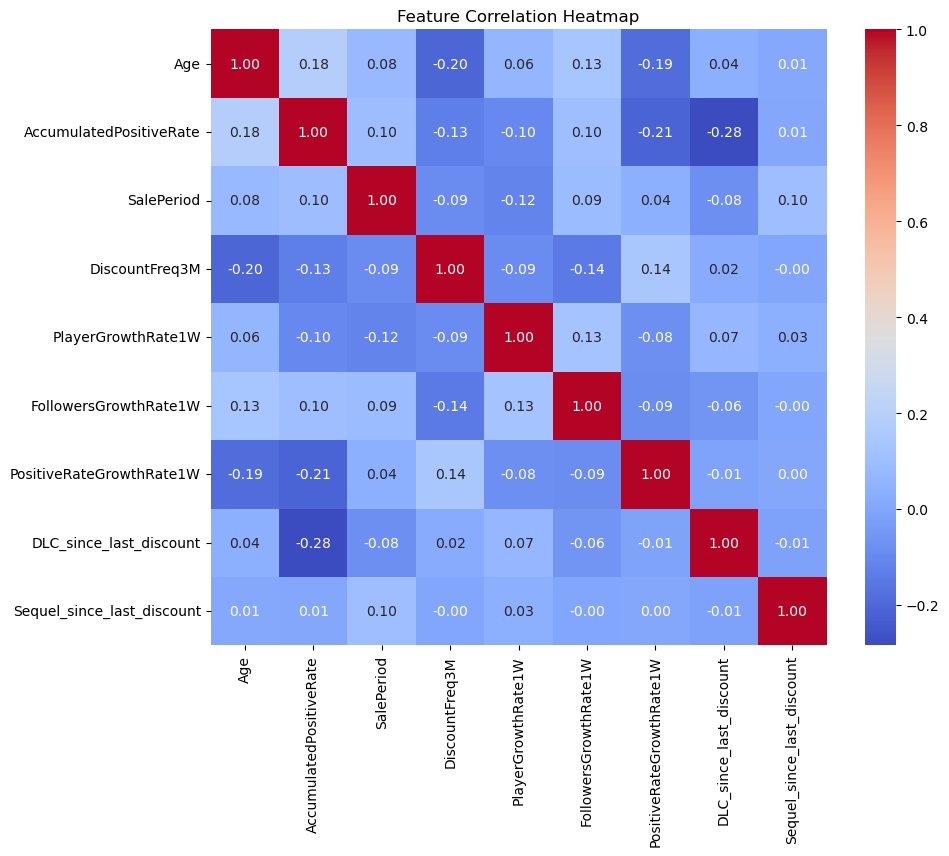

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# 只選數值型特徵（排除目標變數與時間）
features = ["Age", "AccumulatedPositiveRate", "SalePeriod",
            "DiscountFreq3M", "PlayerGrowthRate1W", "FollowersGrowthRate1W",
            "PositiveRateGrowthRate1W", "DLC_since_last_discount",
            "Sequel_since_last_discount"]

corr = df[features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Feature Correlation Heatmap")
plt.show()



Feature Importances:


,Feature,Importance
1,AccumulatedPositiveRate,0.390545
7,FollowersGrowthRate2W,0.138609
0,Age,0.137421
8,PositiveRateGrowthRate2W,0.107650
6,PlayerGrowthRate2W,0.079377
2,DiscountDuration,0.077797
4,MultiPlayer,0.034408
3,DiscountFreq3M,0.026333
5,SalePeriod,0.007860



=== baseline ===


,Best Params,Train R²,Test R²,Train RMSE,Test RMSE
result,N/A,0.7621,0.6241,0.0956,0.1122



Feature Importances:


,Feature,Importance
1,AccumulatedPositiveRate,0.378990
0,Age,0.153103
7,FollowersGrowthRate2W,0.137784
8,PositiveRateGrowthRate2W,0.106272
2,DiscountDuration,0.079296
6,PlayerGrowthRate2W,0.077673
4,MultiPlayer,0.034487
3,DiscountFreq3M,0.023081
5,SalePeriod,0.009313



=== selection ===


,Best Params,Train R²,Test R²,Train RMSE,Test RMSE
result,N/A,0.8058,0.678,0.0864,0.1038


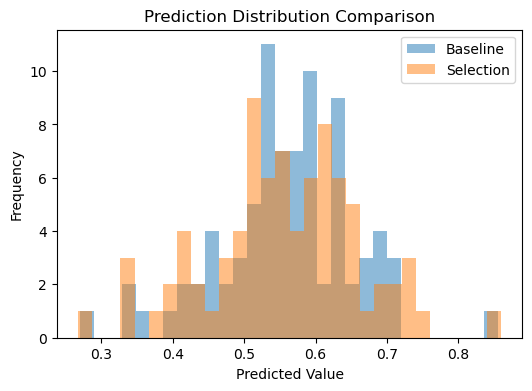

In [15]:
def compare_prediction_distributions(preds, labels):
    plt.figure(figsize=(6,4))

    for y_pred, label in zip(preds, labels):
        plt.hist(y_pred, bins=30, alpha=0.5, label=label)

    plt.title("Prediction Distribution Comparison")
    plt.xlabel("Predicted Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
result1, y_pred_baseline = evaluate_model("baseline", baseline_model, X_train, y_train, X_test, y_test)
result2, y_pred_selection = evaluate_model("selection", model, X_train, y_train, X_test, y_test)

compare_prediction_distributions(
    [y_pred_baseline, y_pred_selection],
    ["Baseline", "Selection"]
)


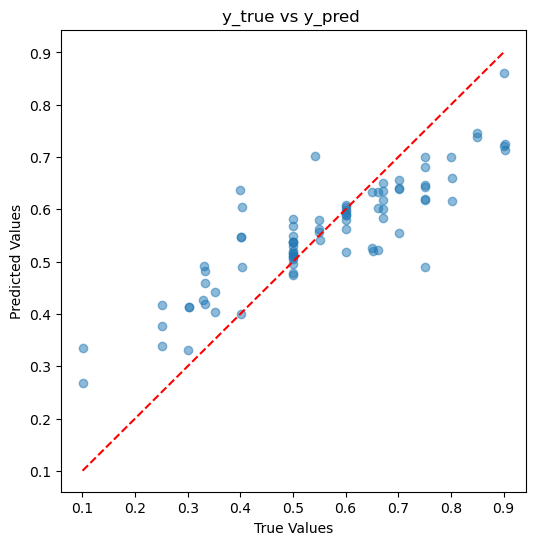

In [18]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_selection, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], 
         [y_test.min(), y_test.max()], 
         'r--')  # 理想45度線
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title(f"y_true vs y_pred ")
plt.show()
